# demo1
## demonstrate the detailed construction of the novel transformer with cognitive information

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline
import Dina
from Dina import McmcHoDina
from Dina import MlDina
import pandas as pd
from utils import r4beta
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import progressbar
#from transformer import MyDataSet, Transformer

In [2]:
def get_attn_pad_mask(seq_q, seq_k, batch_size):
    '''
    seq_q: [batch_size, seq_len]
    seq_k: [batch_size, seq_len]
    seq_len could be src_len or it could be tgt_len
    seq_len in seq_q and seq_len in seq_k maybe not equal
    '''
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    # eq(zero) is PAD token
    pad_attn_mask = seq_k.data.eq(0).unsqueeze(1)  # [batch_size, 1, len_k], False is masked
    return pad_attn_mask.expand(batch_size, len_q, len_k)  # [batch_size, len_q, len_k]

def get_attn_subsequence_mask(seq):
    '''
    seq: [batch_size, tgt_len]
    '''
    attn_shape = [seq.size(0), seq.size(1), seq.size(1)]
    subsequence_mask = np.triu(np.ones(attn_shape), k=1) # Upper triangular matrix
    subsequence_mask = torch.from_numpy(subsequence_mask).byte()
    return subsequence_mask # [batch_size, tgt_len, tgt_len]

class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_k):
        super(ScaledDotProductAttention, self).__init__()
        self.d_k = d_k

    def forward(self, Q, K, V, attn_mask):
        '''
        Q: [batch_size, n_heads, len_q, d_k]
        K: [batch_size, n_heads, len_k, d_k]
        V: [batch_size, n_heads, len_v(=len_k), d_v]
        attn_mask: [batch_size, n_heads, seq_len, seq_len]
        '''
        scores = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(self.d_k) # scores : [batch_size, n_heads, len_q, len_k]
        scores.masked_fill_(attn_mask, -1e9) # Fills elements of self tensor with value where mask is True.
        
        attn = nn.Softmax(dim=-1)(scores)
        context = torch.matmul(attn, V) # [batch_size, n_heads, len_q, d_v]
        return context, attn

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, d_k, d_v, n_heads=8):
        super(MultiHeadAttention, self).__init__()
        self.d_model = d_model
        self.d_k = d_k
        self.d_v = d_v
        self.n_heads = n_heads
        self.W_Q = nn.Linear(d_model, d_k * self.n_heads, bias=False)
        self.W_K = nn.Linear(d_model, d_k * self.n_heads, bias=False)
        self.W_V = nn.Linear(d_model, d_v * self.n_heads, bias=False)
        self.fc = nn.Linear(n_heads * d_v, d_model, bias=False)
        
    def forward(self, input_Q, input_K, input_V, attn_mask):
        '''
        input_Q: [batch_size, len_q, d_model]
        input_K: [batch_size, len_k, d_model]
        input_V: [batch_size, len_v(=len_k), d_model]
        attn_mask: [batch_size, seq_len, seq_len]
        '''
        residual, batch_size = input_Q, input_Q.size(0)
        # (B, S, D) -proj-> (B, S, D_new) -split-> (B, S, H, W) -trans-> (B, H, S, W)
        Q = self.W_Q(input_Q).view(batch_size, -1, self.n_heads, self.d_k).transpose(1,2)  # Q: [batch_size, n_heads, len_q, d_k]
        K = self.W_K(input_K).view(batch_size, -1, self.n_heads, self.d_k).transpose(1,2)  # K: [batch_size, n_heads, len_k, d_k]
        V = self.W_V(input_V).view(batch_size, -1, self.n_heads, self.d_v).transpose(1,2)  # V: [batch_size, n_heads, len_v(=len_k), d_v]

        attn_mask = attn_mask.unsqueeze(1).repeat(1, self.n_heads, 1, 1) # attn_mask : [batch_size, n_heads, seq_len, seq_len]

        # context: [batch_size, n_heads, len_q, d_v], attn: [batch_size, n_heads, len_q, len_k]
        context, attn = ScaledDotProductAttention(self.d_k)(Q, K, V, attn_mask)
        context = context.transpose(1, 2).reshape(batch_size, -1, self.n_heads * self.d_v) # context: [batch_size, len_q, n_heads * d_v]
        output = self.fc(context) # [batch_size, len_q, d_model]
        return nn.LayerNorm(self.d_model)(output + residual), attn

class PoswiseFeedForwardNet(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff
        self.fc = nn.Sequential(
            nn.Linear(self.d_model, self.d_ff, bias=False),
            nn.ReLU(),
            nn.Linear(self.d_ff, self.d_model, bias=False)
        )
    def forward(self, inputs):
        '''
        inputs: [batch_size, seq_len, d_model]
        '''
        residual = inputs
        output = self.fc(inputs)
        return nn.LayerNorm(self.d_model)(output + residual) # [batch_size, seq_len, d_model]

class EncoderLayer(nn.Module):
    def __init__(self, d_model, d_ff, d_k, d_v):
        super(EncoderLayer, self).__init__()
        self.enc_self_attn = MultiHeadAttention(d_model, d_k, d_v)
        self.pos_ffn = PoswiseFeedForwardNet(d_model, d_ff)

    def forward(self, enc_inputs, enc_self_attn_mask):
        '''
        enc_inputs: [batch_size, src_len, d_model]
        enc_self_attn_mask: [batch_size, src_len, src_len]
        '''
        # enc_outputs: [batch_size, src_len, d_model], attn: [batch_size, n_heads, src_len, src_len]
        enc_outputs, attn = self.enc_self_attn(enc_inputs, enc_inputs, enc_inputs, enc_self_attn_mask) # enc_inputs to same Q,K,V
        enc_outputs = self.pos_ffn(enc_outputs) # enc_outputs: [batch_size, src_len, d_model]
        return enc_outputs, attn

class DecoderLayer(nn.Module):
    def __init__(self, d_model, d_ff, d_k, d_v):
        super(DecoderLayer, self).__init__()
        self.dec_self_attn = MultiHeadAttention(d_model, d_k, d_v)
        self.dec_enc_attn = MultiHeadAttention(d_model, d_k, d_v)
        self.pos_ffn = PoswiseFeedForwardNet(d_model, d_ff)

    def forward(self, dec_inputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask):
        '''
        dec_inputs: [batch_size, tgt_len, d_model]
        enc_outputs: [batch_size, src_len, d_model]
        dec_self_attn_mask: [batch_size, tgt_len, tgt_len]
        dec_enc_attn_mask: [batch_size, tgt_len, src_len]
        '''
        # dec_outputs: [batch_size, tgt_len, d_model], dec_self_attn: [batch_size, n_heads, tgt_len, tgt_len]
        dec_outputs, dec_self_attn = self.dec_self_attn(dec_inputs, dec_inputs, dec_inputs, dec_self_attn_mask)
        # dec_outputs: [batch_size, tgt_len, d_model], dec_enc_attn: [batch_size, h_heads, tgt_len, src_len]
        dec_outputs, dec_enc_attn = self.dec_enc_attn(dec_outputs, enc_outputs, enc_outputs, dec_enc_attn_mask)
        dec_outputs = self.pos_ffn(dec_outputs) # [batch_size, tgt_len, d_model]
        return dec_outputs, dec_self_attn, dec_enc_attn

class Encoder(nn.Module):
    def __init__(self, num_items, d_model, d_ff, d_k, d_v, n_layers, n_heads, batch_size):
        super(Encoder, self).__init__()
        self.batch_size = batch_size
        self.src_emb = nn.Embedding(num_items, d_model)
        #self.pos_emb = PositionalEncoding(d_model)
        self.layers = nn.ModuleList([EncoderLayer(d_model, d_ff, d_k, d_v) for _ in range(n_layers)])

    def forward(self, enc_inputs):
        '''
        enc_inputs: [batch_size, src_len]
        '''
        #print("c1:", enc_inputs.shape)
        enc_outputs = self.src_emb(enc_inputs) # [batch_size, src_len, d_model]
        #print("c2:", enc_outputs.shape)
        #print("cut1:", enc_outputs.shape)
        #enc_outputs = self.pos_emb(enc_outputs.transpose(0, 1)).transpose(0, 1) # [batch_size, src_len, d_model]
        #print("cut2:", enc_outputs.shape)
        enc_self_attn_mask = get_attn_pad_mask(enc_inputs, enc_inputs, self.batch_size) # [batch_size, src_len, src_len]
        enc_self_attns = []
        for layer in self.layers:
            # enc_outputs: [batch_size, src_len, d_model], enc_self_attn: [batch_size, n_heads, src_len, src_len]
            enc_outputs, enc_self_attn = layer(enc_outputs, enc_self_attn_mask)
            enc_self_attns.append(enc_self_attn)
        return enc_outputs, enc_self_attns

class Decoder(nn.Module):
    def __init__(self, num_items, d_model, d_ff, d_k, d_v, n_layers, n_heads, batch_size):
        super(Decoder, self).__init__()
        self.batch_size = batch_size
        self.tgt_emb = nn.Embedding(num_items, d_model)
        #self.pos_emb = PositionalEncoding(d_model)
        self.layers = nn.ModuleList([DecoderLayer(d_model, d_ff, d_k, d_v) for _ in range(n_layers)])

    def forward(self, dec_inputs, enc_inputs, enc_outputs):
        '''
        dec_inputs: [batch_size, tgt_len]
        enc_intpus: [batch_size, src_len]
        enc_outputs: [batsh_size, src_len, d_model]
        '''
        #print("c1:", dec_inputs.shape)
        dec_outputs = self.tgt_emb(dec_inputs) # [batch_size, tgt_len, d_model]
        #print("c2:", dec_outputs.shape)
        #print("cut1:", enc_outputs.shape)
        #dec_outputs = self.pos_emb(dec_outputs.transpose(0, 1)).transpose(0, 1) # [batch_size, tgt_len, d_model]
        #print("cut2:", enc_outputs.shape)
        dec_self_attn_pad_mask = get_attn_pad_mask(dec_inputs, dec_inputs, self.batch_size) # [batch_size, tgt_len, tgt_len]
        dec_self_attn_subsequence_mask = get_attn_subsequence_mask(dec_inputs) # [batch_size, tgt_len, tgt_len]
        dec_self_attn_mask = torch.gt((dec_self_attn_pad_mask + dec_self_attn_subsequence_mask), 0) # [batch_size, tgt_len, tgt_len]

        dec_enc_attn_mask = get_attn_pad_mask(dec_inputs, enc_inputs, self.batch_size) # [batc_size, tgt_len, src_len]

        dec_self_attns, dec_enc_attns = [], []
        for layer in self.layers:
            # dec_outputs: [batch_size, tgt_len, d_model], dec_self_attn: [batch_size, n_heads, tgt_len, tgt_len], dec_enc_attn: [batch_size, h_heads, tgt_len, src_len]
            dec_outputs, dec_self_attn, dec_enc_attn = layer(dec_outputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask)
            dec_self_attns.append(dec_self_attn)
            dec_enc_attns.append(dec_enc_attn)
        return dec_outputs, dec_self_attns, dec_enc_attns


    
class Transformer(nn.Module):
    def __init__(self, num_items, num_skills, d_model=512, d_ff=2048, d_k=64, d_v=64, n_layers=6, n_heads=8, batch_size=10):
        super(Transformer, self).__init__()
        self.num_items = num_items
        self.num_skills = num_skills
        self.d_model = d_model
        self.d_ff = d_ff
        self.d_k = d_k
        self.d_v = d_v
        self.n_layers = n_layers;
        self.n_heads = n_heads
        self.batch_size = batch_size
        self.encoder = Encoder(num_items, d_model, d_ff, d_k, d_v, n_layers, n_heads, batch_size)
        self.decoder = Decoder(num_items, d_model, d_ff, d_k, d_v, n_layers, n_heads, batch_size)
        self.projection = nn.Linear(num_skills * d_model, num_items, bias=False)
        
    def forward(self, enc_inputs, dec_inputs):
        '''
        enc_inputs: [batch_size, src_len]
        dec_inputs: [batch_size, tgt_len]
        '''
        # tensor to store decoder outputs
        # outputs = torch.zeros(batch_size, tgt_len, num_items).to(self.device)
        
        # enc_outputs: [batch_size, src_len, d_model], enc_self_attns: [n_layers, batch_size, n_heads, src_len, src_len]
        enc_outputs, enc_self_attns = self.encoder(enc_inputs)
        # dec_outpus: [batch_size, tgt_len, d_model], dec_self_attns: [n_layers, batch_size, n_heads, tgt_len, tgt_len], dec_enc_attn: [n_layers, batch_size, tgt_len, src_len]
        dec_outputs, dec_self_attns, dec_enc_attns = self.decoder(dec_inputs, enc_inputs, enc_outputs)
        # dec_outputs: [50, 8, 512]
        #print(dec_outputs.view(dec_outputs.shape[0], -1).shape)
        dec_logits = self.projection(dec_outputs.view(dec_outputs.shape[0], -1)) # dec_logits: [batch_size, num_items]
        return dec_logits.view(-1, dec_logits.size(-1)), enc_self_attns, dec_self_attns, dec_enc_attns


class MyDataSet(Data.Dataset):
    def __init__(self, enc_inputs, dec_inputs, dec_outputs):
        super(MyDataSet, self).__init__()
        self.enc_inputs = enc_inputs
        self.dec_inputs = dec_inputs
        self.dec_outputs = dec_outputs

    def __len__(self):
        return self.enc_inputs.shape[0]

    def __getitem__(self, idx):
        return self.enc_inputs[idx], self.dec_inputs[idx], self.dec_outputs[idx]

In [3]:
def load_data(path, ratio):
    full_data = pd.read_csv(path + 'data.txt', header=None, sep='\t').values
    q_matrix = pd.read_csv(path + 'q.txt', header=None, sep='\t').values
    num_samples, num_items, num_skills = full_data.shape[0], full_data.shape[1], q_matrix.shape[1]
    
    train_data = full_data[ : int(num_samples * ratio)]
    train_data = binary_classify(train_data)
    test_data = full_data[int(num_samples * ratio): ]
    test_data = binary_classify(test_data)
    
    return train_data, test_data, q_matrix, num_samples, num_items, num_skills

def binary_classify(data):
    data[data <= 0.5] = 0
    data[data > 0.5] = 1
    return data.astype(np.int64)

def get_scores(pred_scores, true_scores):

    fpr, tpr, thresholds = metrics.roc_curve(true_scores, pred_scores)
    # accuracy, precision, recall, f1
    accuracy = accuracy_score(true_scores, pred_scores)
    precision = precision_score(true_scores, pred_scores)
    recall = recall_score(true_scores, pred_scores)
    f1 = f1_score(true_scores, pred_scores)
    
    roc_auc = roc_auc_score(true_scores, pred_scores)

    return accuracy, precision, recall, f1, fpr, tpr, thresholds, roc_auc

def get_prior_skills(x, y, q_matrix):
    guess = r4beta(1, 2, 0, 0.6, (1, x.shape[1]))
    slip = r4beta(1, 2, 0, 0.6, (1, x.shape[1]))
    max_iter = 100
    tol = 1e-5
    EmDina = Dina.EmDina(guess, slip, max_iter, tol, q_matrix, x)
    est_s, est_g = EmDina.em()
    dina_est = Dina.MlDina(est_g, est_s, q_matrix, y)
    est_skills = dina_est.get_skills_by_Ml()
    return est_skills

In [4]:
train_data1, test_data1, q_matrix1, num_samples1, num_items1, num_skills1 = load_data('./FrcSub/', 0.8)
train_data2, test_data2, q_matrix2, num_samples2, num_items2, num_skills2 = load_data('./Math1/', 0.8)
train_data3, test_data3, q_matrix3, num_samples3, num_items3, num_skills3 = load_data('./Math2/', 0.8)
batch_size1 = int(num_samples1 / 50)
batch_size2 = int(num_samples2 / 50)
batch_size3 = int(num_samples3 / 50)
epoch_size = 50

In [5]:
num_samples, num_items, num_skills, batch_size = num_samples1, num_items1, num_skills1, batch_size1
x_train, y_train, x_test, y_test, q_matrix = train_data1, train_data1, test_data1, test_data1, q_matrix1

src_len = num_items # enc_input max sequence length
tgt_len = num_items # dec_input(=dec_output) max sequence length

est_skills = get_prior_skills(x_train, y_train, q_matrix)

enc_inputs = torch.LongTensor(x_train)
dec_inputs = torch.LongTensor(est_skills)
dec_outputs = torch.FloatTensor(y_train)

In [37]:
loader = Data.DataLoader(MyDataSet(enc_inputs, dec_inputs, dec_outputs), batch_size, True)
model = Transformer(num_items, num_skills, d_model=512, d_ff=64, d_k=16, d_v=16, n_layers=3, n_heads=8, batch_size=batch_size)
loss_func = nn.MSELoss()
#optimizer = optim.SGD(model.parameters(), lr=1e-3)
optimizer =optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

loss_his, accuracy_his, precision_his, recall_his, f1_his, fpr_his, roc_auc_his = [], [], [], [], [], [], []
for epoch in range(100):

    for enc_inputs_batch, dec_inputs_batch, dec_outputs_batch in loader:

        outputs_batch, enc_self_attns, dec_self_attns, dec_enc_attns = model(enc_inputs_batch, dec_inputs_batch)

        #print(outputs.shape, dec_outputs.shape) # outputs[400, 20]: 400 = 50(batch_size) * 8(tgt_len), 20(tgt_vocab_size) # dec_outputs[50, 8]: [batch_size, tgt_len]
        #break
        loss = loss_func(outputs_batch, dec_outputs_batch)
        if (epoch + 1) == 100:
            loss_his.append(loss.data.item())
        #print(loss.dtype)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'loss =', '{:.6f}'.format(loss))
    # get RMSE on test dataset:
    with torch.no_grad():
        est_skills = get_prior_skills(x_test, y_test, q_matrix)
        enc_inputs = torch.LongTensor(x_test)
        dec_inputs = torch.LongTensor(est_skills)
        dec_outputs = torch.FloatTensor(y_test)
        outputs, enc_self_attns, dec_self_attns, dec_enc_attns = model(enc_inputs, dec_inputs)
        predict = outputs.detach().numpy()
        predict = binary_classify(predict)
        pred = predict.reshape(-1)
        true = y_test.reshape(-1)
    accuracy, precision, recall, f1, fpr, tpr, thresholds, roc_auc = get_scores(pred, true)
    
    accuracy_his.append(accuracy)
    precision_his.append(precision)
    recall_his.append(recall)
    f1_his.append(f1)
    roc_auc_his.append(roc_auc)
print("Accuracy: {:4.6f} | Precision: {:4.6f} | Recall: {:4.6f} | F1: {:4.6f} | AUC: {:4.6f}".format(accuracy, precision, recall, f1, roc_auc))

Epoch: 0010 loss = 0.119776
Epoch: 0020 loss = 0.114088
Epoch: 0030 loss = 0.106438
Epoch: 0040 loss = 0.072542
Epoch: 0050 loss = 0.080762
Epoch: 0060 loss = 0.090820
Epoch: 0070 loss = 0.082468
Epoch: 0080 loss = 0.065380
Epoch: 0090 loss = 0.076688
Epoch: 0100 loss = 0.058517
Accuracy: 0.916204 | Precision: 0.923486 | Recall: 0.888548 | F1: 0.905680 | AUC: 0.913817


In [39]:
torch.save(model.state_dict(), './demo1_state_dict_Frbsub.pt')

In [51]:
def draw_scores(dataset, accuracy_his, precision_his, recall_his, f1_his, roc_auc_his):
    xrange = np.arange(0,100)
    plt.xlim(0, 101)
    plt.ylim(0.5, 1.0)
    plt.xlabel('Epoch')
    plt.ylabel('Scores')
    plt.title(dataset)
    #plt.plot(fpr_list[0], tpr_list[0], color='darkorange', lw=2, label='Frbsub (area = %0.3f)' % roc_auc_list[0])
    plt.plot(xrange, accuracy_his, color='r', label='Rmse')
    plt.plot(xrange, precision_his, color='g', label='Precision')
    plt.plot(xrange, recall_his, color='orange', label='Recall')
    plt.plot(xrange, f1_his, color='navy', label='F1')
    plt.plot(xrange, roc_auc_his, color='purple', label='AUC')
    plt.legend(loc="lower right")
    plt.savefig('scores_Frbsub.png')

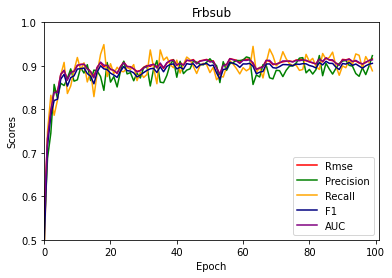

In [52]:
draw_scores('Frbsub', accuracy_his, precision_his, recall_his, f1_his, roc_auc_his)

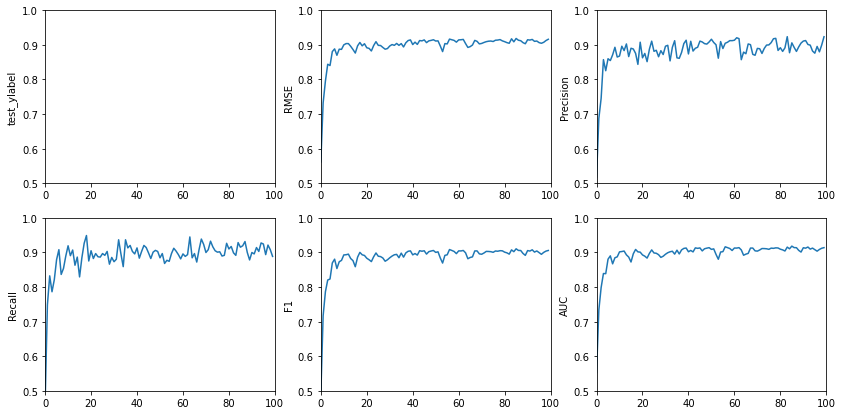

In [38]:
fig, ax = plt.subplots(2, 3, figsize=(14,7))

ax[0][0].set_xlim(0, 100)
ax[0][0].set_ylim(0.5, 1.0)
#ax[0][0].set_xlabel('epochs')
ax[0][0].set_ylabel('test_ylabel')
#ax[0][0].set_title('RMSE')

ax[0][1].set_xlim(0, 100)
ax[0][1].set_ylim(0.5, 1.)
ax[0][1].set_ylabel('RMSE')
ax[0][1].plot(accuracy_his)

ax[0][2].set_xlim(0, 100)
ax[0][2].set_ylim(0.5, 1.)
ax[0][2].set_ylabel('Precision')
ax[0][2].plot(precision_his)


ax[1][0].set_xlim(0, 100)
ax[1][0].set_ylim(0.5, 1.)
ax[1][0].set_ylabel('Recall')
ax[1][0].plot(recall_his)

ax[1][1].set_xlim(0, 100)
ax[1][1].set_ylim(0.5, 1.)
ax[1][1].set_ylabel('F1')
ax[1][1].plot(f1_his)

ax[1][2].set_xlim(0, 100)
ax[1][2].set_ylim(0.5, 1.)
ax[1][2].set_ylabel('AUC')
ax[1][2].plot(roc_auc_his)